# Import Libraries 

In [1]:
from tqdm import tqdm
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from   torchvision import datasets, transforms
import torch.optim as optim
from   torch.optim.lr_scheduler import StepLR
from   torchinfo import summary

import albumentations as A
from   albumentations.pytorch import ToTensorV2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import models as cifar_models
import utils as myutils

# Set the GPU device

In [2]:
# Is GPU available
device = torch.device("cpu")
is_gpu_available = False

if torch.cuda.is_available():
    print("CUDA is available")
    device = torch.device("cuda:0")
    is_gpu_available = True
elif torch.backends.mps.is_available():
    print("Apple MPS is available")
    device = torch.device("mps:0")
    is_gpu_available = True

torch.set_default_device(device)

Apple MPS is available


# Download and prepare the dataset

In [3]:
# To get over the following error:
# URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
batch_size = 2048
# Train Phase transformations
train_transforms = myutils.Transforms(transforms=A.Compose([
    A.HorizontalFlip(p=0.25),
    A.ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, interpolation=1, 
        border_mode=4, value=None, mask_value=None, shift_limit_x=None, shift_limit_y=None, 
        rotate_method='largest_box', always_apply=False, p=0.5,
    ),
    A.CoarseDropout(
        max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
        min_width=16, fill_value=0.48, mask_fill_value=None, always_apply=False, p=0.5,
    ),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Test Phase transformations
test_transforms = myutils.Transforms(transforms=A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2(),
]))

# Data
train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

# Data loaders
dataloader_args = dict(shuffle=False, batch_size=batch_size, num_workers=4, pin_memory=True) if is_gpu_available else dict(shuffle=True, batch_size=64)

# train dataloader
train_data_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)
# test dataloader
test_data_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print("classes: ", train_data.class_to_idx)
# {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
classes:  {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


## Look at the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dict_keys(['image'])


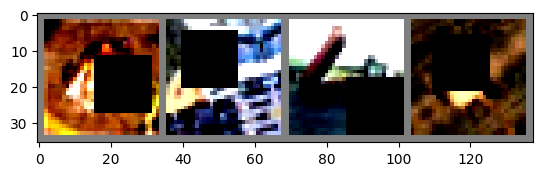

frog  truck truck deer 


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_data_loader)
data, labels = next(dataiter)
print(data.keys())
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# show images
imshow(torchvision.utils.make_grid(data['image'][:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Model

# Summary

In [6]:
model = cifar_models.Net().to(device)
summary(model=model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 32, 32, 32]           4,736
│    └─ReLU: 2-2                         [1, 32, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 32, 32, 32]           64
├─Sequential: 1-2                        [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 32, 32, 32]           832
│    └─Conv2d: 2-5                       [1, 64, 32, 32]           2,112
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 64, 32, 32]           128
│    └─Dropout: 2-8                      [1, 64, 32, 32]           --
├─Sequential: 1-3                        [1, 64, 30, 30]           --
│    └─Conv2d: 2-9                       [1, 64, 30, 30]           36,928
│  

# Train and test the model

In [7]:
model = cifar_models.Net().to(device)

criterion = F.nll_loss
optimizer = optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

train_losses = []
test_losses = []
train_acc = []
test_acc = []

EPOCHS = 50
for epoch in range(EPOCHS):
    # Train
    train_epoch_accuracy = myutils.train(model, train_data_loader, criterion, optimizer, epoch, train_losses, train_acc, device)
    # scheduler.step()
    # Test
    test_epoch_accuracy = myutils.test(model, test_data_loader, epoch, test_losses, test_acc, device)
    # 
    if train_epoch_accuracy >= 85 or test_epoch_accuracy >= 85:
        break

Epoch=0 Batch_id=24 Loss=1.965278148651123 Accuracy=20.83: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:41<00:00,  1.67s/it]



Test set: Average loss: 2.0804, Accuracy: 1814/10000 (18.14%)



Epoch=1 Batch_id=24 Loss=1.8346540927886963 Accuracy=29.91: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.7748, Accuracy: 3505/10000 (35.05%)



Epoch=2 Batch_id=24 Loss=1.732689380645752 Accuracy=33.75: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.6896, Accuracy: 3793/10000 (37.93%)



Epoch=3 Batch_id=24 Loss=1.6823186874389648 Accuracy=36.05: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.6485, Accuracy: 4008/10000 (40.08%)



Epoch=4 Batch_id=24 Loss=1.6509678363800049 Accuracy=37.52: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.5770, Accuracy: 4236/10000 (42.36%)



Epoch=5 Batch_id=24 Loss=1.6111654043197632 Accuracy=39.66: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.5533, Accuracy: 4321/10000 (43.21%)



Epoch=6 Batch_id=24 Loss=1.5868251323699951 Accuracy=40.42: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.5153, Accuracy: 4496/10000 (44.96%)



Epoch=7 Batch_id=24 Loss=1.5317500829696655 Accuracy=41.88: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.4680, Accuracy: 4644/10000 (46.44%)



Epoch=8 Batch_id=24 Loss=1.550533652305603 Accuracy=42.61: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.4536, Accuracy: 4697/10000 (46.97%)



Epoch=9 Batch_id=24 Loss=1.4994202852249146 Accuracy=43.78: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.54s/it]



Test set: Average loss: 1.4424, Accuracy: 4751/10000 (47.51%)



Epoch=10 Batch_id=24 Loss=1.5085763931274414 Accuracy=44.69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3845, Accuracy: 4996/10000 (49.96%)



Epoch=11 Batch_id=24 Loss=1.4563310146331787 Accuracy=45.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3895, Accuracy: 4942/10000 (49.42%)



Epoch=12 Batch_id=24 Loss=1.4653818607330322 Accuracy=45.99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3831, Accuracy: 5006/10000 (50.06%)



Epoch=13 Batch_id=24 Loss=1.4203499555587769 Accuracy=46.97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.3471, Accuracy: 5120/10000 (51.20%)



Epoch=14 Batch_id=24 Loss=1.4358811378479004 Accuracy=47.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.4034, Accuracy: 4910/10000 (49.10%)



Epoch=15 Batch_id=24 Loss=1.377224326133728 Accuracy=47.60: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.2888, Accuracy: 5358/10000 (53.58%)



Epoch=16 Batch_id=24 Loss=1.3923147916793823 Accuracy=49.02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.3004, Accuracy: 5294/10000 (52.94%)



Epoch=17 Batch_id=24 Loss=1.3534537553787231 Accuracy=49.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.2739, Accuracy: 5428/10000 (54.28%)



Epoch=18 Batch_id=24 Loss=1.3249672651290894 Accuracy=49.84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.2697, Accuracy: 5475/10000 (54.75%)



Epoch=19 Batch_id=24 Loss=1.3240736722946167 Accuracy=49.99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.2643, Accuracy: 5521/10000 (55.21%)



Epoch=20 Batch_id=24 Loss=1.3510324954986572 Accuracy=50.39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.2533, Accuracy: 5513/10000 (55.13%)



Epoch=21 Batch_id=24 Loss=1.2887208461761475 Accuracy=50.75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.2708, Accuracy: 5417/10000 (54.17%)



Epoch=22 Batch_id=24 Loss=1.2862505912780762 Accuracy=51.46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.2425, Accuracy: 5592/10000 (55.92%)



Epoch=23 Batch_id=24 Loss=1.2962027788162231 Accuracy=52.24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.2012, Accuracy: 5742/10000 (57.42%)



Epoch=24 Batch_id=24 Loss=1.245137333869934 Accuracy=52.56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.2059, Accuracy: 5674/10000 (56.74%)



Epoch=25 Batch_id=24 Loss=1.2950003147125244 Accuracy=52.79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.2018, Accuracy: 5717/10000 (57.17%)



Epoch=26 Batch_id=24 Loss=1.2641839981079102 Accuracy=53.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.58s/it]



Test set: Average loss: 1.1937, Accuracy: 5708/10000 (57.08%)



Epoch=27 Batch_id=24 Loss=1.2629117965698242 Accuracy=53.85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.58s/it]



Test set: Average loss: 1.1481, Accuracy: 5877/10000 (58.77%)



Epoch=28 Batch_id=24 Loss=1.243963599205017 Accuracy=54.57: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.1629, Accuracy: 5841/10000 (58.41%)



Epoch=29 Batch_id=24 Loss=1.2097197771072388 Accuracy=54.60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 1.1141, Accuracy: 6077/10000 (60.77%)



Epoch=30 Batch_id=24 Loss=1.2461838722229004 Accuracy=54.28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1712, Accuracy: 5876/10000 (58.76%)



Epoch=31 Batch_id=24 Loss=1.1872013807296753 Accuracy=55.14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1108, Accuracy: 6026/10000 (60.26%)



Epoch=32 Batch_id=24 Loss=1.2100696563720703 Accuracy=55.42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1105, Accuracy: 6029/10000 (60.29%)



Epoch=33 Batch_id=24 Loss=1.1932108402252197 Accuracy=56.32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 1.1365, Accuracy: 5979/10000 (59.79%)



Epoch=34 Batch_id=24 Loss=1.1988297700881958 Accuracy=52.36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.1349, Accuracy: 5938/10000 (59.38%)



Epoch=35 Batch_id=24 Loss=1.1778419017791748 Accuracy=56.07: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.58s/it]



Test set: Average loss: 1.1473, Accuracy: 5898/10000 (58.98%)



Epoch=36 Batch_id=24 Loss=1.1898038387298584 Accuracy=56.60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0636, Accuracy: 6165/10000 (61.65%)



Epoch=37 Batch_id=24 Loss=1.180742621421814 Accuracy=57.02: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.0838, Accuracy: 6092/10000 (60.92%)



Epoch=38 Batch_id=24 Loss=1.159998893737793 Accuracy=57.19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 1.0507, Accuracy: 6264/10000 (62.64%)



Epoch=39 Batch_id=24 Loss=1.1628060340881348 Accuracy=57.23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0577, Accuracy: 6244/10000 (62.44%)



Epoch=40 Batch_id=24 Loss=1.1346120834350586 Accuracy=57.55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.58s/it]



Test set: Average loss: 1.0758, Accuracy: 6181/10000 (61.81%)



Epoch=41 Batch_id=24 Loss=1.125480055809021 Accuracy=57.56: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.58s/it]



Test set: Average loss: 1.0338, Accuracy: 6301/10000 (63.01%)



Epoch=42 Batch_id=24 Loss=1.1465705633163452 Accuracy=58.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 1.0578, Accuracy: 6201/10000 (62.01%)



Epoch=43 Batch_id=24 Loss=1.171953558921814 Accuracy=58.28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0310, Accuracy: 6332/10000 (63.32%)



Epoch=44 Batch_id=24 Loss=1.1314544677734375 Accuracy=58.01: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 1.0046, Accuracy: 6457/10000 (64.57%)



Epoch=45 Batch_id=24 Loss=1.1259692907333374 Accuracy=58.93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 1.0015, Accuracy: 6422/10000 (64.22%)



Epoch=46 Batch_id=24 Loss=1.105750560760498 Accuracy=59.22: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.57s/it]



Test set: Average loss: 1.0482, Accuracy: 6252/10000 (62.52%)



Epoch=47 Batch_id=24 Loss=1.081739068031311 Accuracy=59.30: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.55s/it]



Test set: Average loss: 0.9747, Accuracy: 6573/10000 (65.73%)



Epoch=48 Batch_id=24 Loss=1.0458307266235352 Accuracy=60.00: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:38<00:00,  1.56s/it]



Test set: Average loss: 0.9928, Accuracy: 6466/10000 (64.66%)



Epoch=49 Batch_id=24 Loss=1.1065419912338257 Accuracy=60.09: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:39<00:00,  1.56s/it]



Test set: Average loss: 0.9919, Accuracy: 6453/10000 (64.53%)



# Visualise

## Training and Testing

Text(0.5, 1.0, 'Test Accuracy')

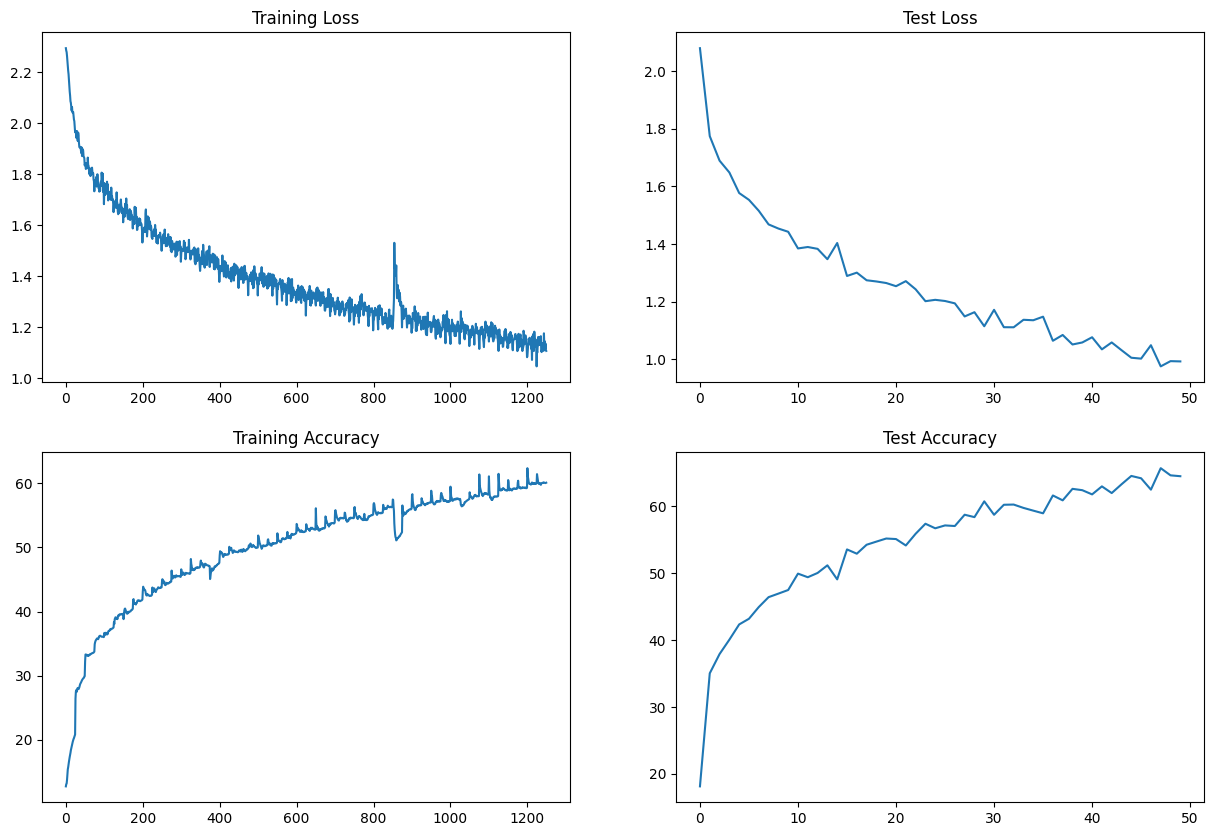

In [8]:
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")